In [3]:
import utility
import pandas as pd

# Only those systems in Chen2023
SYSTEM_ORDER = ["p38", "ptp1b", "tyk2", "mcl1"] # "thrombin"
# SYSTEM_ORDER = ["p38", "ptp1b", "tyk2", "mcl1"]
FORCE_FIELD_ORDER = ['espaloma-0.3.1', 'gaff-2.11', 'openff-2.0.0', 'Chen2023']


In [4]:
BindFlowData = pd.read_csv("../data/simulation/bindflow/gather/BindFlow.csv", index_col=0)

columns = [
    "system",
    "ligand",
    "replica",
    "sample",
    "exp_dG",
    "exp_dG_error",
    "simulation_mbar_espaloma-0.3.1",
    "simulation_mbar_gaff-2.11",
    "simulation_mbar_openff-2.0.0",
    "simulation_Chen2023",
]
BindFlowData = BindFlowData[columns]

BindFlowData.rename(
    columns={
        "system": "source",
        "simulation_mbar_espaloma-0.3.1": "simulation_espaloma-0.3.1",
        "simulation_mbar_gaff-2.11": "simulation_gaff-2.11",
        "simulation_mbar_openff-2.0.0": "simulation_openff-2.0.0",
    },
    inplace=True
)

In [5]:
mean = BindFlowData.groupby(["source", "ligand"]).mean().reset_index().drop(columns=["replica", "sample"])
sem = BindFlowData.groupby(["source", "ligand"]).sem().reset_index().drop(columns=["replica", "sample"])


# Filter DataFrame
mask = mean["simulation_Chen2023"].notna() & (mean["simulation_espaloma-0.3.1"].notna()) & (mean["source"] != "thrombin")
mean = mean[mask]
sem = sem[mask]

sem.rename(
    columns={
        "simulation_espaloma-0.3.1": "sem_espaloma-0.3.1",
        "simulation_gaff-2.11": "sem_gaff-2.11",
        "simulation_openff-2.0.0": "sem_openff-2.0.0",
        "simulation_Chen2023": "sem_Chen2023"
    },
    inplace=True
)
sem.drop(columns=["exp_dG", "exp_dG_error"], inplace=True)
df_merge = pd.merge(mean, sem, on=["source", "ligand"])
df_merge

,source,ligand,exp_dG,exp_dG_error,simulation_espaloma-0.3.1,simulation_gaff-2.11,simulation_openff-2.0.0,simulation_Chen2023,sem_espaloma-0.3.1,sem_gaff-2.11,sem_openff-2.0.0,sem_Chen2023
0,mcl1,lig_27,-6.12,0.12,-7.574892,-6.891967,-6.715143,-10.161537,0.235520,0.563953,0.132694,0.177749
1,mcl1,lig_28,-6.62,0.03,-6.417333,-6.976999,-4.981864,-9.901650,0.610286,0.890570,1.082247,0.335842
2,mcl1,lig_30,-7.85,0.19,-8.097288,-7.417434,-7.728127,-10.754567,0.437260,0.259519,0.777868,0.058340
3,mcl1,lig_31,-7.92,0.03,-9.780229,-7.158434,-8.512434,-11.387267,0.231054,0.315972,0.352700,0.259718
4,mcl1,lig_32,-6.58,0.12,-8.096669,-7.606603,-8.741955,-10.386167,0.164307,0.031303,0.867775,0.058085
...,...,...,...,...,...,...,...,...,...,...,...,...
84,tyk2,lig_ejm_54,-10.63,0.18,-12.628961,-12.536255,-13.602891,-13.744300,0.398893,0.508927,0.526663,0.186165
85,tyk2,lig_ejm_55,-9.29,0.18,-15.239058,-9.660865,-12.039963,-14.155000,1.418296,1.363233,0.857949,0.264866
86,tyk2,lig_jmc_23,-11.81,0.18,-15.518173,-10.002343,-12.745145,-15.075233,1.254362,0.575457,0.516661,0.249168
87,tyk2,lig_jmc_27,-11.38,0.18,-15.064844,-11.333263,-12.784466,-14.463733,1.722972,1.146720,1.073732,0.305438


In [6]:
replicates = 10_000
confidence = 68

In [7]:
import numpy as np
df_mse_removed = df_merge.copy()
for ff in FORCE_FIELD_ORDER:
    for system_name in SYSTEM_ORDER:
        system_index = df_merge["source"] == system_name
        
        mse = (df_merge.loc[system_index,f"simulation_{ff}"] - df_merge.loc[system_index,"exp_dG"]).mean()
        df_mse_removed.loc[system_index,f"simulation_{ff}"] -= mse
        
        # uncertainty of the difference
        difference_uncertainty = np.sqrt(df_merge.loc[system_index,"exp_dG_error"]**2 + df_merge.loc[system_index,f"sem_{ff}"]**2)
        # uncertainty of the mean
        mse_uncertainty = np.sqrt(np.sum(difference_uncertainty**2)) / len(system_index)
        # uncertainty of the difference
        df_mse_removed.loc[system_index,f"sem_{ff}"] = np.sqrt(df_merge.loc[system_index,f"sem_{ff}"]**2 + mse_uncertainty**2)

In [8]:
df_merge.source.unique()

array(['mcl1', 'p38', 'ptp1b', 'tyk2'], dtype=object)

Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

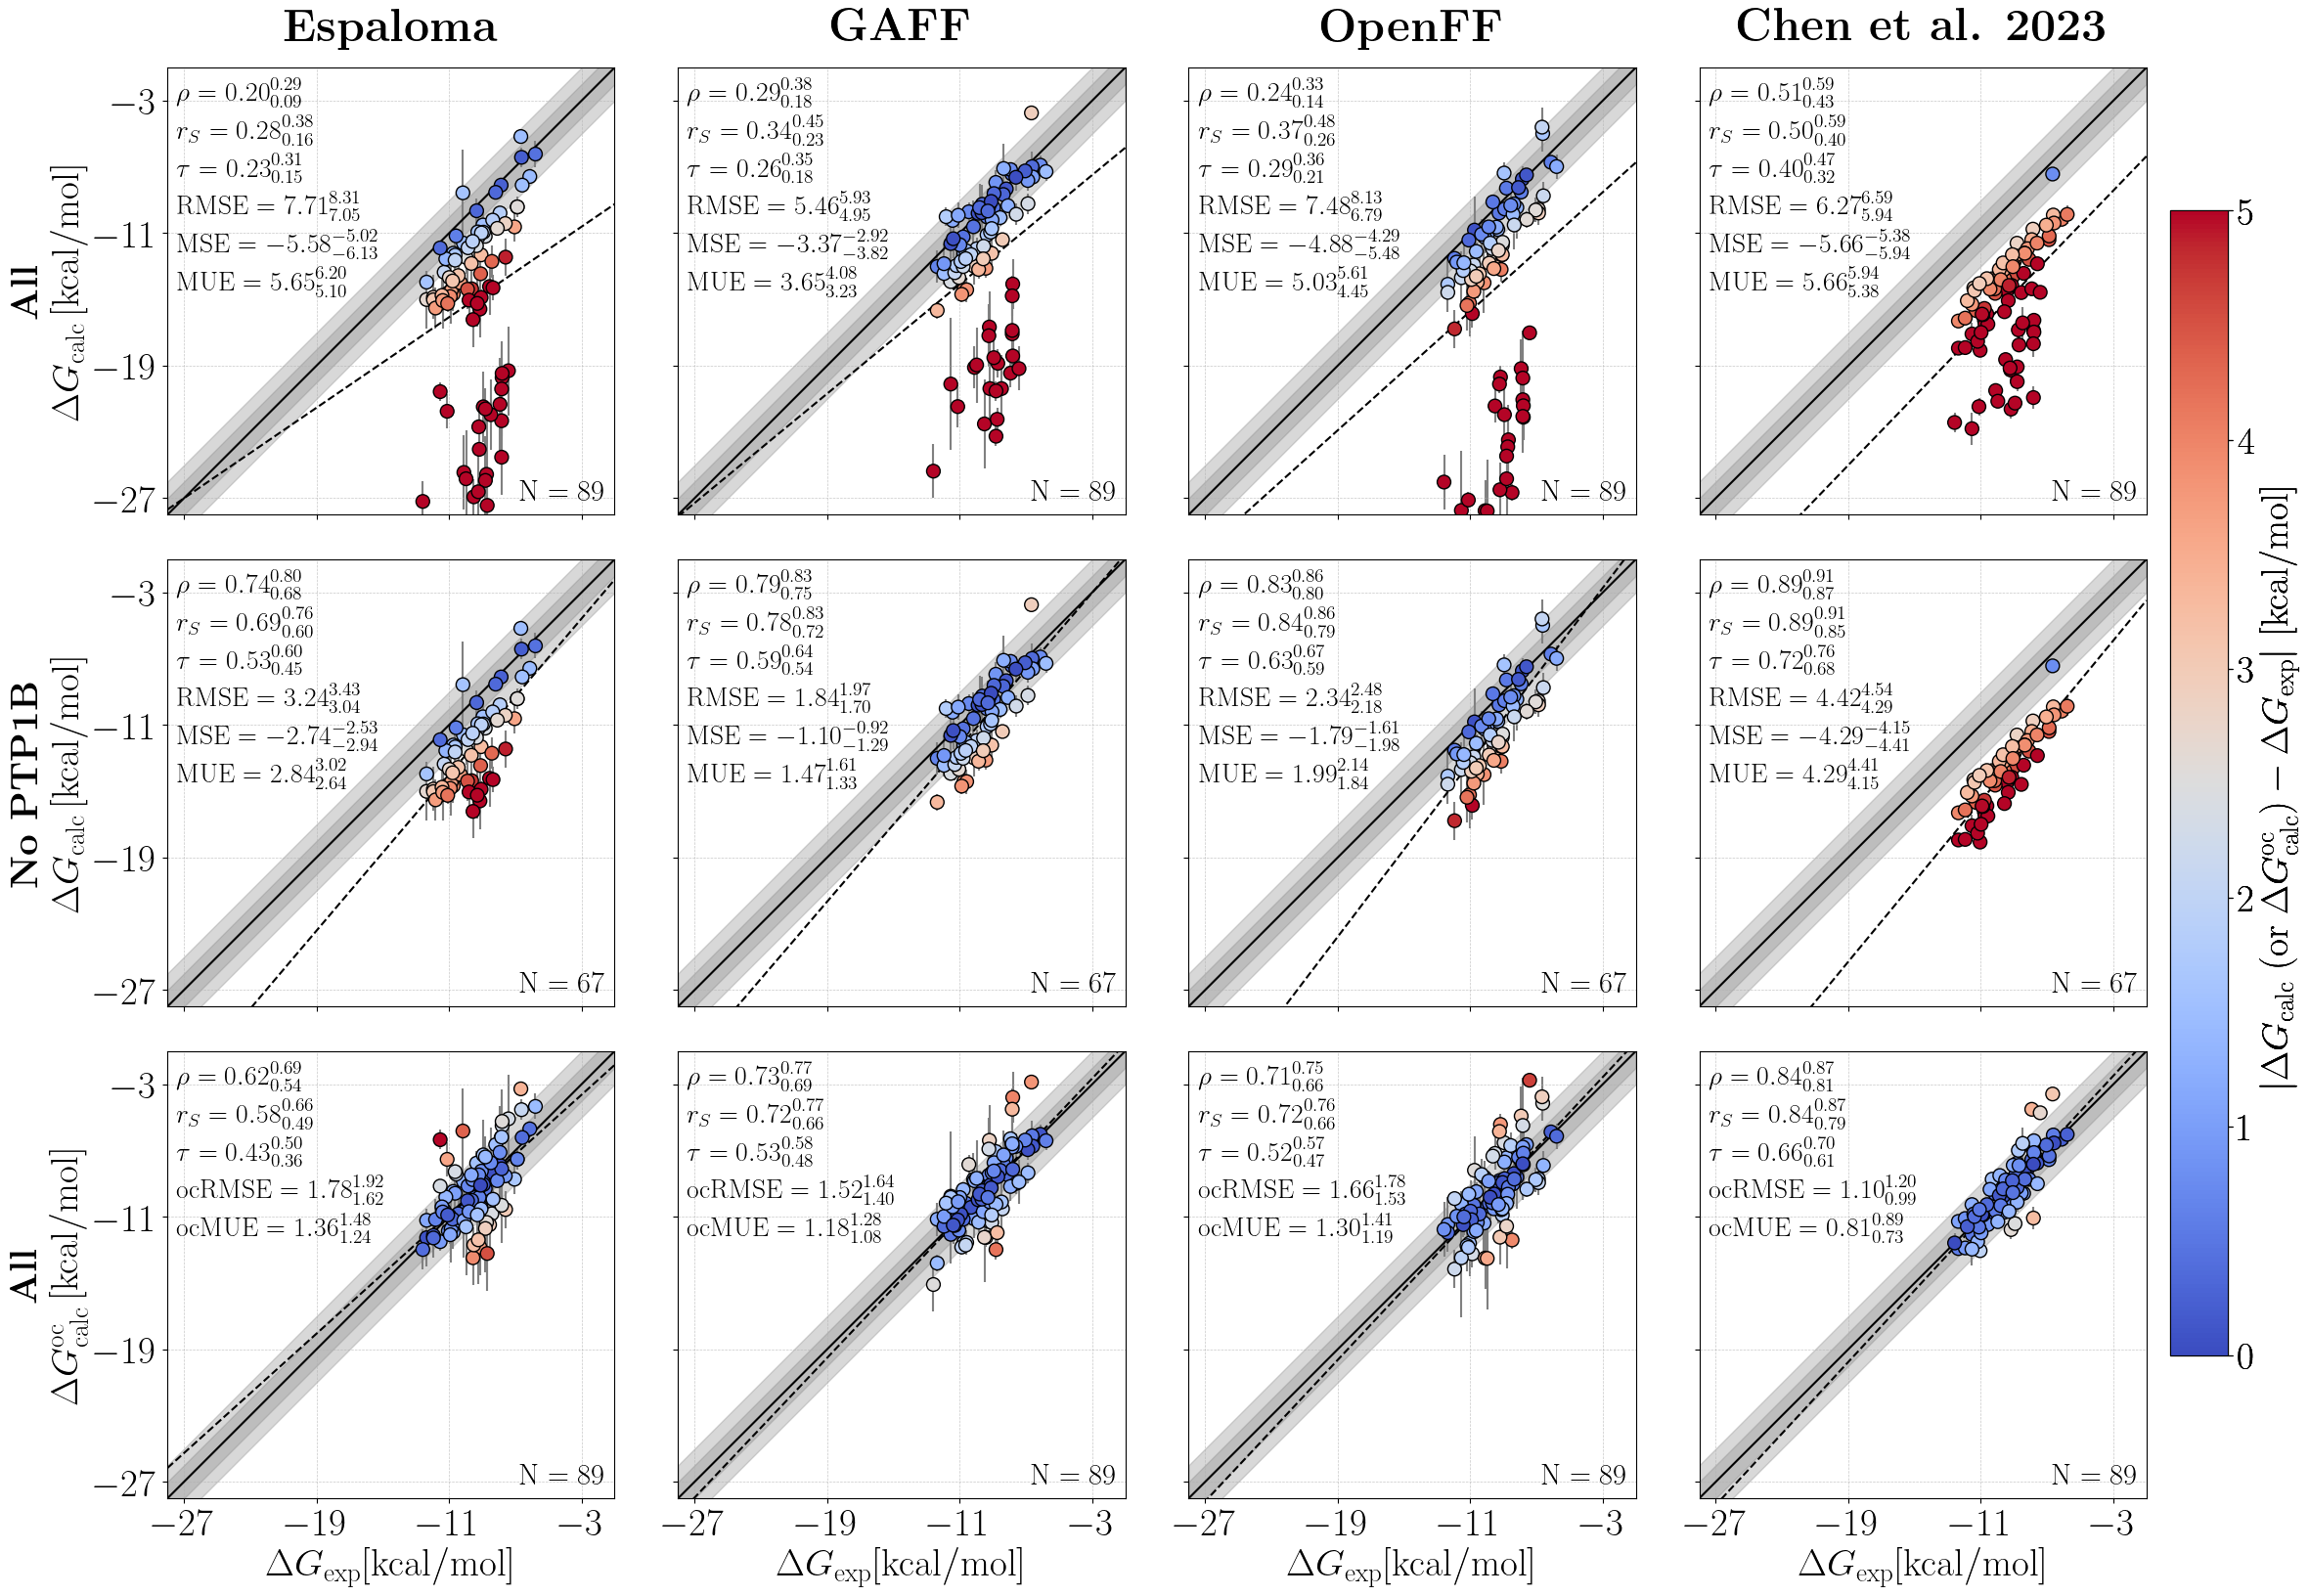

In [9]:
ax, fig = utility.make_publication_plot2(
    dfs=[df_merge, df_merge[df_merge["source"] != "ptp1b"], df_mse_removed],
    name_list=["All", "No PTP1B", "All"],
    figsize=(32,19), replicates=replicates, confidence=confidence)
fig.savefig(f"summary/external/ff-collapsed-mbar-Chen2023-{'-'.join(SYSTEM_ORDER)}.pdf",
            bbox_inches="tight",  # trims whitespace
            pad_inches=0.0,       # removes extra padding
            transparent=False)

Thrombin does not seem to be right because there is not a good correlation experimental vs experimental used on the study. Which makes rise some alarms. See the thrombin notebook.